# Visual Attention between Area Of Interest

In [1]:
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
import json
import modules.GenSnippetsLib as snippets
from pygments.lexers import PythonLexer
from tqdm.notebook import tqdm
import PIL
import PIL.Image
import numpy as np
from skimage.draw import ellipse
from mpl_chord_diagram import chord_diagram
import os
plt.rcParams['savefig.facecolor']='white'

In [2]:
#check if folder exists
if not os.path.exists("./results/RQ2/chord"):
    os.makedirs("./results/RQ2/chord")

## Load The Data

In [3]:
def click_data_to_list(click_data_string):
    click_data_list = []
    for click in click_data_string.split(" "):
        click = click.split("-")
        # extract the x and y coordinates from a string via regex
        x = int(re.search(r'\d+', click[0])[0])
        y = int(re.search(r'\d+', click[1])[0])
        click_data_list.append((x, y))
    return click_data_list#

def time_data_to_list(time_data_string):
    time_data_list = []
    for time in time_data_string.split(" "):
        time_data_list.append(float(time) / 1000)
    return time_data_list

In [4]:
df = pd.read_csv('./data/preprocessed_experiment_data.csv')
df = df[df["Outlier"] == False]
df = df.drop(columns=["Outlier"])

df["ClickData"] = df["ClickData"].apply(lambda x: click_data_to_list(x))
df["TimeData"] = df["TimeData"].apply(lambda x: time_data_to_list(x))
df["NumberOfClicks"] = df["ClickData"].apply(lambda x: len(x))
df["AverageTimeOfClicks"] = (df["ResponseTime"] / 1000) / df["NumberOfClicks"]

## Create the Bounding Boxes of the Areas of Interest

In [5]:
# prepare color mapping for aois
algorithms = df[["Algorithm"]].sort_values(by="Algorithm")["Algorithm"].unique()
programming_styles = df[["ProgrammingStyle"]].sort_values(by="ProgrammingStyle")["ProgrammingStyle"].unique()
algorithms = [x for x in algorithms]
programming_styles = [x.replace("-", "_") for x in programming_styles]

color_palette = sns.color_palette("hls", 16)
color_palette_mapping = {
    "Method" : color_palette[0],
    "MethodDeclaration" : color_palette[1],
    "MethodBody" : color_palette[2],
    "Helper" : color_palette[3],
    "HelperDeclaration" : color_palette[4],
    "HelperBody" : color_palette[5],
    "Iteration" : color_palette[6],
    "IterationHead" : color_palette[7],
    "IterationBody" : color_palette[8],
    "RecursiveCall" : color_palette[9],
    "RecursiveBaseCase" : color_palette[10],
    "HigherOrder" : color_palette[11],
    "ListComprehension" : color_palette[12],
    "InputPreparation" : color_palette[13],
    "StartOfAlgorithm" : color_palette[14],
    "Class" : color_palette[15],
}
aoi_colors = color_palette
aoi_numbers = {name : idx for idx, (name, _value) in enumerate(color_palette_mapping.items())}
aoi_names = [name for name, _value in color_palette_mapping.items()]

def aoi_idx_to_convoluted_idx(aoi_idx):
    if aoi_idx < 5:
        return aoi_idx
    if 6 <= aoi_idx <= 12:
        return 6
    if 13 <= aoi_idx:
        return aoi_idx-6

def aoi_name_to_convoluted_name(aoi_name):
    if aoi_name in ["Iteration", "IterationHead", "IterationBody",
                    "Recursion", "RecursiveCall", "RecursiveBaseCase",
                    "HigherOrder",
                    "ListComprehension"]:
        return "StyleSpecific"
    return aoi_name

color_palette = sns.color_palette("hls", 10)
color_palette_mapping_convoluted = {
    "Method" : color_palette[0],
    "MethodDeclaration" : color_palette[1],
    "MethodBody" : color_palette[2],
    "Helper" : color_palette[3],
    "HelperDeclaration" : color_palette[4],
    "HelperBody" : color_palette[5],
    "StyleSpecific" : color_palette[6],
    "InputPreparation" : color_palette[7],
    "StartOfAlgorithm" : color_palette[8],
    "Class" : color_palette[9],
}
aoi_colors_convoluted = color_palette
aoi_numbers_convoluted = {name : idx for idx, (name, _value) in enumerate(color_palette_mapping_convoluted.items())}
aoi_names_convoluted = [name for name, _value in color_palette_mapping_convoluted.items()]

In [6]:
# create bounding boxes and visualize them
def from_canvas(fig):
    lst = list(fig.canvas.get_width_height())
    lst.append(3)
    return PIL.Image.fromarray(np.frombuffer(fig.canvas.tostring_rgb(),dtype=np.uint8).reshape(lst))

df_bounding_box = pd.DataFrame(columns=["Algorithm", "ProgrammingStyle", "BoundingBoxes", "ImageDimension"])
font_path="\\data\\fonts\\ttf\\"
offset = 3


for algorithm in tqdm(algorithms):
    for programming_style in programming_styles:
        # load the image and generate bb code info
        file_name = './data/CodeSnippets/Generators/' + algorithm + '_' + programming_style + '.json'
        try:
            image, result = snippets.create_image(file_name, font_path=font_path, lexer=PythonLexer)
            y, x = image.size[::-1]
            dimension = (x, y)
        except Exception as e:
            print(file_name + ":" + str(e))
            continue
        # extract the areas of interest in the image
        areas_of_interest = set()
        for letter in result:
            for aoi in letter["AOI"]:
                areas_of_interest.add(aoi)

        # create the bounding boxes
        disjoint_areas_of_interest = []
        for aoi in areas_of_interest:
            upper_left_x = 0
            upper_left_y = 0
            lower_right_x = 0
            lower_right_y = 0
            has_aoi = False
            for letter in result:
                if letter["BoundingBox"][0] == 0 and letter["BoundingBox"][1] == 0 and letter["BoundingBox"][2] == 0 and letter["BoundingBox"][3] == 0:
                    continue

                if aoi in letter["AOI"]:
                    if not has_aoi:
                        upper_left_x = letter["BoundingBox"][0] - offset
                        upper_left_y = letter["BoundingBox"][1] - offset
                        lower_right_x = letter["BoundingBox"][2] + offset
                        lower_right_y = letter["BoundingBox"][3] + offset
                        has_aoi = True
                    else:
                        upper_left_x = min(upper_left_x, letter["BoundingBox"][0] - offset)
                        upper_left_y = min(upper_left_y, letter["BoundingBox"][1] - offset)
                        lower_right_x = max(lower_right_x, letter["BoundingBox"][2] + offset)
                        lower_right_y = max(lower_right_y, letter["BoundingBox"][3] + offset)
                else:
                    if has_aoi:
                        disjoint_areas_of_interest.append((aoi, [upper_left_x, upper_left_y, lower_right_x, lower_right_y]))
                    has_aoi = False
                    upper_left_x = 0
                    upper_left_y = 0
                    lower_right_x = 0
                    lower_right_y = 0

            if has_aoi:
                disjoint_areas_of_interest.append((aoi, [upper_left_x, upper_left_y, lower_right_x, lower_right_y]))

        # create the bounding boxes without None aoi
        disjoint_areas_of_interest = [area for area in disjoint_areas_of_interest if area[0] != "None"]
        df_bounding_box.loc[len(df_bounding_box)] = [algorithm, programming_style.replace("_", "-"), disjoint_areas_of_interest, dimension]
df_bounding_box

  0%|          | 0/11 [00:00<?, ?it/s]

,Algorithm,ProgrammingStyle,BoundingBoxes,ImageDimension
0,LinkedList,higher-order,"[(Method, [2, 655, 593, 754]), (StartOfAlgorit...","(594, 1206)"
1,LinkedList,iterative,"[(IterationHead, [2, 603, 344, 624]), (Method,...","(362, 1154)"
2,LinkedList,list-comprehension,"[(Method, [2, 655, 705, 779]), (StartOfAlgorit...","(706, 1232)"
3,LinkedList,recursive,"[(Method, [2, 239, 504, 416]), (RecursiveCall,...","(506, 868)"
4,apply,higher-order,"[(Method, [2, 5, 312, 52]), (StartOfAlgorithm,...","(394, 166)"
5,apply,iterative,"[(IterationHead, [2, 58, 224, 78]), (Method, [...","(394, 244)"
6,apply,list-comprehension,"[(Method, [2, 5, 376, 52]), (StartOfAlgorithm,...","(394, 166)"
7,apply,recursive,"[(Method, [2, 5, 560, 130]), (RecursiveCall, [...","(562, 244)"
8,computer,higher-order,"[(Method, [2, 369, 880, 416]), (StartOfAlgorit...","(882, 738)"
9,computer,iterative,"[(IterationHead, [2, 422, 288, 442]), (Method,...","(738, 842)"


## Map the Visual Attention Measures to the Areas of Interest

In [7]:
def get_ellipse_mask(center, x_radius, y_radius, dimension, std_value = 1.0):
    """
    Returns a mask of an ellipse with the given center, x-radius, and y-radius.
    """
    x_dim = max(center[0]+2*x_radius+1, dimension[0])
    y_dim = max(center[1]+2*y_radius+1, dimension[1])
    mask = np.zeros((y_dim, x_dim), dtype=np.float32)
    rr, cc = ellipse(center[1], center[0], y_radius, x_radius)
    mask[rr, cc] = std_value
    mask = mask[:dimension[1], :dimension[0]]
    return mask

def get_rectangular_mask(points, dimension, std_value = 1.0):
    """
    Returns a mask of a rectangular with the given points.
    """
    x_dim = max(points[2]+1, dimension[0])
    y_dim = max(points[3]+1, dimension[1])
    mask = np.zeros((y_dim, x_dim), dtype=np.float32)
    mask[points[1]:points[3]+1, points[0]:points[2]+1] = std_value
    mask = mask[:dimension[1], :dimension[0]]
    return mask

In [8]:
settings = json.load(open("./data/settings.json"))
x_radius = settings["radius_x"]+settings["grad_radius"]//2
y_radius = settings["radius_y"]+settings["grad_radius"]//2

df = pd.merge(df, df_bounding_box, on=["Algorithm", "ProgrammingStyle"])

In [9]:
df

,ID,ProgrammingStyle,Algorithm,ResponseTime,Correctness,ClickData,TimeData,NumberOfClicks,AverageTimeOfClicks,BoundingBoxes,ImageDimension
0,212,iterative,apply,66794,False,"[(268, 191), (151, 70), (151, 70), (146, 89), ...","[10.105, 34.435, 35.005, 39.192, 47.146, 56.58...",8,8.349250,"[(IterationHead, [2, 58, 224, 78]), (Method, [...","(394, 244)"
1,245,iterative,apply,21078,True,"[(156, 17), (174, 195), (129, 44), (131, 62), ...","[1.123, 3.472, 14.145, 14.878, 16.035, 19.911,...",7,3.011143,"[(IterationHead, [2, 58, 224, 78]), (Method, [...","(394, 244)"
2,272,iterative,apply,81561,True,"[(188, 192), (104, 34), (132, 69), (149, 89)]","[16.519, 78.023, 79.043, 81.561]",4,20.390250,"[(IterationHead, [2, 58, 224, 78]), (Method, [...","(394, 244)"
3,296,iterative,apply,22825,False,"[(160, 195), (122, 115), (148, 9), (138, 34), ...","[4.194, 11.386, 13.568, 14.369, 15.567, 17.215...",8,2.853125,"[(IterationHead, [2, 58, 224, 78]), (Method, [...","(394, 244)"
4,302,iterative,apply,20310,True,"[(69, 204), (84, 191), (150, 197), (254, 200),...","[4.193, 5.008, 5.85, 6.351, 8.856, 10.441, 11....",9,2.256667,"[(IterationHead, [2, 58, 224, 78]), (Method, [...","(394, 244)"
...,...,...,...,...,...,...,...,...,...,...,...
273,213,list-comprehension,LinkedList,153552,False,"[(42, 22), (65, 45), (51, 123), (81, 143), (11...","[4.155, 9.379, 12.561, 13.652, 21.857, 23.971,...",51,3.010824,"[(Method, [2, 655, 705, 779]), (StartOfAlgorit...","(706, 1232)"
274,252,list-comprehension,LinkedList,47933,True,"[(110, 12), (118, 37), (101, 117), (126, 142),...","[3.853, 4.218, 8.66, 9.02, 9.434, 9.893, 11.02...",39,1.229051,"[(Method, [2, 655, 705, 779]), (StartOfAlgorit...","(706, 1232)"
275,297,list-comprehension,LinkedList,48782,True,"[(80, 9), (90, 33), (88, 125), (103, 146), (10...","[3.545, 4.213, 6.711, 7.143, 7.7, 8.598, 9.962...",37,1.318432,"[(Method, [2, 655, 705, 779]), (StartOfAlgorit...","(706, 1232)"
276,309,list-comprehension,LinkedList,55439,False,"[(78, 15), (80, 37), (81, 117), (109, 146), (1...","[3.924, 4.856, 5.841, 6.974, 7.497, 8.04, 10.4...",36,1.539972,"[(Method, [2, 655, 705, 779]), (StartOfAlgorit...","(706, 1232)"


In [10]:
df_aoi = pd.DataFrame([], columns=["Algorithm", "ProgrammingStyle", "Participant", "Number", "Duration", "AOI", "Correctness"])
iteration_categroies = ["Iteration", "IterationHead", "IterationBody"]
recursive_categroies = ["RecursiveCall", "RecursiveBaseCase"]
list_comprehension_categroies = ["ListComprehension"]
higher_order_categroies = ["HigherOrder"]

for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    algorithm = row["Algorithm"]
    programming_style = row["ProgrammingStyle"]
    dimension = row["ImageDimension"]
    clicks = row["ClickData"]
    participant = row["ID"]
    correctness = row["Correctness"]

    duration_per_click = row["TimeData"]
    duration_tmp = [duration_per_click[0]]
    for duration_idx, value in enumerate(duration_per_click):
        if duration_idx == 0:
            continue
        duration_tmp.append(value-duration_per_click[duration_idx-1])
    duration_per_click = duration_tmp

    bounding_boxes = row["BoundingBoxes"]
    mask_bounding_boxes = [get_rectangular_mask(bounding_box, dimension) for _, bounding_box in bounding_boxes]
    names_of_bounding_boxes = [aoi_name for aoi_name, _ in bounding_boxes]

    for idx, (click, duration) in enumerate(zip(clicks, duration_per_click)):
        # get elliptical mask
        click_mask = get_ellipse_mask(click, x_radius, y_radius, dimension)
        aois_visited = set()
        # check if the click is in the bounding box of an aoi
        for bounding_box_name, bounding_box_mask in zip(names_of_bounding_boxes, mask_bounding_boxes):
            if np.sum(click_mask*bounding_box_mask) > 0:
                aois_visited.add(bounding_box_name)
        aois_visited_tmp = set()
        for aoi_name in aois_visited:
            if aoi_name in iteration_categroies:
                aois_visited_tmp.add("Iteration")
            elif aoi_name in recursive_categroies:
                aois_visited_tmp.add("Recursion")
            elif aoi_name in list_comprehension_categroies:
                aois_visited_tmp.add("ListComprehension")
            elif aoi_name in higher_order_categroies:
                aois_visited_tmp.add("HigherOrder")
            else:
                aois_visited_tmp.add(aoi_name)
        aois_visited = aois_visited_tmp

        df_aoi.loc[len(df_aoi)] = [algorithm, programming_style, participant, idx, duration, aois_visited, correctness]

df_aoi.reset_index(drop=True)
df_aoi

  0%|          | 0/278 [00:00<?, ?it/s]

,Algorithm,ProgrammingStyle,Participant,Number,Duration,AOI,Correctness
0,apply,iterative,212,0,10.105,"{InputPreparation, StartOfAlgorithm}",False
1,apply,iterative,212,1,24.330,"{MethodBody, Method, Iteration}",False
2,apply,iterative,212,2,0.570,"{MethodBody, Method, Iteration}",False
3,apply,iterative,212,3,4.187,"{MethodBody, Method, Iteration}",False
4,apply,iterative,212,4,7.954,"{Method, MethodDeclaration}",False
...,...,...,...,...,...,...,...
6597,LinkedList,list-comprehension,315,20,3.786,{InputPreparation},True
6598,LinkedList,list-comprehension,315,21,0.533,{InputPreparation},True
6599,LinkedList,list-comprehension,315,22,0.468,{InputPreparation},True
6600,LinkedList,list-comprehension,315,23,0.484,{InputPreparation},True


## Calculate Transition Matrix

In [11]:
df_aoi_transition = pd.DataFrame(columns=["ProgrammingStyle", "Algorithm", "Participant", "Kind", "TransitionMatrix"])
for kind in tqdm(["total", "true", "false"]):
    if kind == "total":
        df_sub = df_aoi
    elif kind == "true":
        df_sub = df_aoi[df_aoi["Correctness"] == True]
    else:
        df_sub = df_aoi[df_aoi["Correctness"] == False]

    for (programming_style, algorithm, participant), df_group in df_sub.groupby(["ProgrammingStyle", "Algorithm", "Participant"]):
        df_group = df_group.sort_values(by="Number")
        transition_matrix = np.zeros((len(aoi_names_convoluted), len(aoi_names_convoluted)))
        for idx in range(len(df_group)-1):
            aois_visited_1 = df_group.iloc[idx]["AOI"]
            aois_visited_2 = df_group.iloc[idx+1]["AOI"]
            for aoi_name_1 in aois_visited_1:
                for aoi_name_2 in aois_visited_2:
                    aoi_name_1 = aoi_name_to_convoluted_name(aoi_name_1)
                    aoi_name_2 = aoi_name_to_convoluted_name(aoi_name_2)
                    transition_matrix[aoi_names_convoluted.index(aoi_name_1), aoi_names_convoluted.index(aoi_name_2)] += 1
        transition_matrix = transition_matrix/len(df_group)
        df_aoi_transition.loc[len(df_aoi_transition)] = [programming_style, algorithm, participant, kind, None]
        df_aoi_transition.at[len(df_aoi_transition)-1, "TransitionMatrix"] = transition_matrix
df_aoi_transition

  0%|          | 0/3 [00:00<?, ?it/s]

,ProgrammingStyle,Algorithm,Participant,Kind,TransitionMatrix
0,higher-order,LinkedList,204,total,"[[0.08695652173913043, 0.014492753623188406, 0..."
1,higher-order,LinkedList,230,total,"[[0.09090909090909091, 0.0, 0.0909090909090909..."
2,higher-order,LinkedList,264,total,"[[0.0975609756097561, 0.04878048780487805, 0.0..."
3,higher-order,LinkedList,296,total,"[[0.03225806451612903, 0.0, 0.0322580645161290..."
4,higher-order,LinkedList,313,total,"[[0.0425531914893617, 0.0, 0.0425531914893617,..."
...,...,...,...,...,...
551,recursive,prime_factors,317,false,"[[0.5, 0.041666666666666664, 0.5, 0.0, 0.0, 0...."
552,recursive,quad_mul,295,false,"[[0.6, 0.0, 0.6, 0.0, 0.0, 0.0, 0.6, 0.0, 0.0,..."
553,recursive,store,294,false,"[[0.12658227848101267, 0.0, 0.1265822784810126..."
554,recursive,store,318,false,"[[0.030303030303030304, 0.0, 0.030303030303030..."


In [12]:
df_aoi_transition_tmp = df_aoi_transition
df_transition = pd.DataFrame(columns=["ProgrammingStyle", "Kind", "TransitionMatrix"])
for kind in tqdm(["total", "true", "false"]):
    df_sub = df_aoi_transition_tmp[df_aoi_transition_tmp["Kind"] == kind]
    for programming_style, df_group in df_sub.groupby("ProgrammingStyle"):
        transition_matrix = np.zeros((len(aoi_names_convoluted), len(aoi_names_convoluted)))
        for idx in range(len(df_group)-1):
            transition_matrix += df_group.iloc[idx]["TransitionMatrix"]
        transition_matrix = transition_matrix/len(df_group)
        df_transition.loc[len(df_transition)] = [programming_style, kind, None]
        df_transition.at[len(df_transition)-1, "TransitionMatrix"] = transition_matrix
df_transition

  0%|          | 0/3 [00:00<?, ?it/s]

,ProgrammingStyle,Kind,TransitionMatrix
0,higher-order,total,"[[0.3355797521233509, 0.05275622261314986, 0.3..."
1,iterative,total,"[[0.5196596843847211, 0.0397736106523612, 0.50..."
2,list-comprehension,total,"[[0.3011750918591055, 0.05639484165680418, 0.2..."
3,recursive,total,"[[0.5049710070807852, 0.03978584347699314, 0.4..."
4,higher-order,true,"[[0.3486883771703353, 0.060814427956970334, 0...."
5,iterative,true,"[[0.5107155177260455, 0.032599853406749216, 0...."
6,list-comprehension,true,"[[0.29235057013935245, 0.058000289985985276, 0..."
7,recursive,true,"[[0.5601652400162976, 0.03805559892763271, 0.5..."
8,higher-order,false,"[[0.29081424731109984, 0.028107594502640214, 0..."
9,iterative,false,"[[0.5444426406926407, 0.07683802308802308, 0.4..."


## Chord Diagrams

In [13]:
def chord(data, names, colors, title, path, diagonal_to_zero=False):
    data_tmp = data.copy()
    if diagonal_to_zero:
        np.fill_diagonal(data_tmp, 0)
    fig, ax = plt.subplots(figsize=(15, 15))
    chord_diagram(data_tmp, names=names, colors=colors, ax=ax, use_gradient=True, rotate_names=True)
    plt.tight_layout()
    plt.title(title)
    plt.savefig(path)
    plt.close('all')

In [14]:
kick_outs_names = ["Method", "HelperDeclaration", "HelperBody"]
kick_outs = [aoi_names_convoluted.index(aoi_name) for aoi_name in kick_outs_names]
kick_outs = list(reversed(sorted(kick_outs)))
aoi_names_tmp = [aoi_name for aoi_name in aoi_names_convoluted if aoi_name not in kick_outs_names]
aoi_colors_tmp = [aoi_colors_convoluted[aoi_names_convoluted.index(aoi_name)] for aoi_name in aoi_names_tmp]
for idx in tqdm(range(len(df_transition))):
    programming_style = df_transition["ProgrammingStyle"].values[idx]
    transition_matrix = df_transition["TransitionMatrix"].values[idx]
    kind = df_transition["Kind"].values[idx]
    # kick out the rows and columns in kick_outs
    transition_matrix = np.delete(np.delete(transition_matrix, kick_outs, axis=0), kick_outs, axis=1)
    chord(transition_matrix, aoi_names_tmp, aoi_colors_tmp,
          f"{programming_style}-{kind}: Transition with Self Transitions",
          f"./results/RQ2/chord/RQ2_Chord_{programming_style}_{kind}_WithSelf.png",
          diagonal_to_zero=False)
    chord(transition_matrix, aoi_names_tmp, aoi_colors_tmp,
          f"{programming_style}-{kind} Transition without Self Transitions",
          f"./results/RQ2/chord/RQ2_Chord_{programming_style}_{kind}_WithoutSelf.png",
          diagonal_to_zero=True)

  0%|          | 0/12 [00:00<?, ?it/s]

# Distance between Programming styles and kinds

In [15]:
df_transition

,ProgrammingStyle,Kind,TransitionMatrix
0,higher-order,total,"[[0.3355797521233509, 0.05275622261314986, 0.3..."
1,iterative,total,"[[0.5196596843847211, 0.0397736106523612, 0.50..."
2,list-comprehension,total,"[[0.3011750918591055, 0.05639484165680418, 0.2..."
3,recursive,total,"[[0.5049710070807852, 0.03978584347699314, 0.4..."
4,higher-order,true,"[[0.3486883771703353, 0.060814427956970334, 0...."
5,iterative,true,"[[0.5107155177260455, 0.032599853406749216, 0...."
6,list-comprehension,true,"[[0.29235057013935245, 0.058000289985985276, 0..."
7,recursive,true,"[[0.5601652400162976, 0.03805559892763271, 0.5..."
8,higher-order,false,"[[0.29081424731109984, 0.028107594502640214, 0..."
9,iterative,false,"[[0.5444426406926407, 0.07683802308802308, 0.4..."


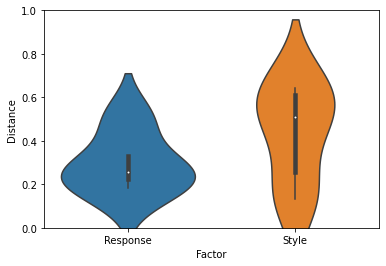

In [16]:
df_distance = pd.DataFrame(columns=["Factor", "Category_a", "Category_b", "Distance"])
for idx, df_group in df_transition.groupby("ProgrammingStyle"):
    matrix_right = df_group[df_group["Kind"] == "true"]["TransitionMatrix"].values[0]
    matrix_wrong = df_group[df_group["Kind"] == "false"]["TransitionMatrix"].values[0]
    distance = np.linalg.norm(matrix_right-matrix_wrong)
    df_distance.loc[len(df_distance)] = ["Response", "true", "false", distance]
df_transition_total = df_transition[df_transition["Kind"] == "total"]
styles = df_transition_total["ProgrammingStyle"].unique()
for idx, style_a in enumerate(styles):
    for style_b in styles[idx+1:]:
        matrix_a = df_transition_total[df_transition_total["ProgrammingStyle"] == style_a]["TransitionMatrix"].values[0]
        matrix_b = df_transition_total[df_transition_total["ProgrammingStyle"] == style_b]["TransitionMatrix"].values[0]
        distance = np.linalg.norm(matrix_a-matrix_b)
        df_distance.loc[len(df_distance)] = ["Style", style_a, style_b, distance]
sns.violinplot(x="Factor", y="Distance", data=df_distance)
plt.ylim(0, 1)
plt.savefig("./results/RQ2/figures/RQ2_Chord_Similarity.png")
plt.show()